## Descripcion:
Modulador GFSK solo para Pluto

Incluye:
 - Generacion de Señal de datos aleatoria
 - Modulacion FSK

Version: 1

## Importamos librerias

In [ ]:
#!pip install scikit-dsp-comm
#!pip install scikit-commpy

In [1]:
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
import commpy
%matplotlib notebook

## Funciones

In [2]:
# Funcion para diseñar un filtro coseno realzado
# Fuente: https://scikit-dsp-comm.readthedocs.io/en/latest/_modules/sk_dsp_comm/sigsys.html
# Parametros:
#    Ns    : int   - Numero de muestras por bit
#    alpha : float - Roll off factor (Valid values are [0, 1]).
#    M     : int   - Cantidad de simbolos que abarca el filtro.
def rc_imp(Ns,alpha,M=6):
    n = np.arange(-int(Ns*M/2),int(Ns*M/2))
    b = np.zeros(len(n))
    print(len(n))
    a = alpha
    Ns = 1.0*Ns
    for i in range(len(n)):
        if (1 - 4*(a*n[i]/Ns)**2) == 0:
            b[i] = (np.pi/4)*np.sinc(1/(2.*a))
        else:
            b[i] = np.sinc(n[i]/Ns)*np.cos(np.pi*a*n[i]/Ns)/(1 - 4*(a*n[i]/Ns)**2)
    return b

In [3]:
# Funcion para diseñar un filtro gauseano
# Fuente: https://github.com/veeresht/CommPy/blob/master/commpy/filters.py
# Parametros
#    Ns    : int   - Numero de muestras por bit
#    B     : float - Ancho de banda.
#    M     : int   - Cantidad de simbolos que abarca el filtro.
def gaussianfilter(Ns, B, M=6):
    n = np.arange(-int(Ns*M/2),int(Ns*M/2))/Ns
    #b = (np.sqrt(np.pi)/alpha)*np.exp(-((np.pi*n/alpha)*(np.pi*n/alpha)))
    #b = (np.sqrt(alpha/np.pi)*np.exp(-(alpha)*(n)**2))*Ns
    K=1
    b = K*np.sqrt(2*np.pi/np.log(2))*B*np.exp((-2*((B*np.pi)**2)*(n**2))/(np.log(2)))
    return b

In [4]:
# Funcion para generar la señal a transmitir.
# Parametros:
# - _TxData -> Datos binarios a transmitir
# - _Ns     -> Numero de muestras por bit
# - _alpha  -> Factor Alpha, no valido para filtro tipo 'rect' (se ignora)
# - _tipo   -> Tipo de filtrado
# - _M      -> Largo del filtro, es en funcion del largo de cada bit
def Generar_señal(_TxData, _Ns, _beta, _tipo, _M=6):
    N_bits = len(_TxData)
    n_zeros = np.zeros((N_bits,int(_Ns)-1))
    x = np.hstack((2*_TxData.reshape(N_bits,1)-1,n_zeros))
    x = x.flatten()
    
    # Interpolado / NRZ 
    b = np.ones(int(_Ns))
    x = signal.lfilter(b,1,x)
    
    if (_tipo.upper() == 'NRZ'):
        # NRZ
        pass
        
    elif (_tipo.upper() == 'RC'):
        # RC
        b = rc_imp(_Ns,_beta,_M)
        x = signal.lfilter(b,1,x)
        
    elif (_tipo.upper() == 'GAUSS'):
        # GAUSS        
        b = gaussianfilter(_Ns,_beta,_M)
        x = signal.lfilter(b,1,x)
        x = x/max(x)
    
    return x, b

## Generamos la señal a transmitir

In [5]:
# Parametros
NroBits = 1000     # Numero de bits a transmitir
fs = 521e3         # Frecuencia de muestreo [Hz]
ts = 1/fs          # Periodo de muestreo [sec]
Tbit = 0.000521    # Tiempo del bit [sec]
Ns = int(fs*Tbit)  # Muestras por bit de dato

Fc = int(1e9)      # [Hz] Frecuencia de portadora
DeltaF = 10000

# Datos random
TxData = np.random.randint(2,size=NroBits)

<IPython.core.display.Javascript object>


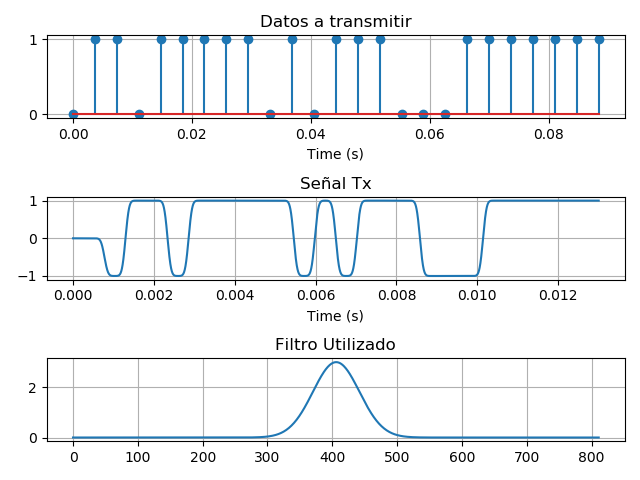

In [28]:
# Parametros para la modulacion
Tipo = 'gauss'   # Tipo de filtro a utilizar [nrz, rc, gauss]
Beta = 1       # Beta para el filtro gauseano
M=3

# Generacion de la FSK
Señal_Tx, Pulse_shape = Generar_señal(TxData, Ns, _beta=Beta, _tipo=Tipo, _M=M)
t = np.arange(len(Señal_Tx))

# Plot
plt.figure()
plt.subplot(311)
plt.stem(ts*t[0:25]/Tbit,TxData[0:25], use_line_collection=True)
plt.title("Datos a transmitir")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(312)
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.title("Señal Tx")
plt.xlabel('Time (s)')
plt.grid()
plt.subplot(313)
plt.plot(Pulse_shape)
plt.title("Filtro Utilizado")
plt.grid()
plt.tight_layout()
plt.show()

## Diagrama de ojo

<IPython.core.display.Javascript object>


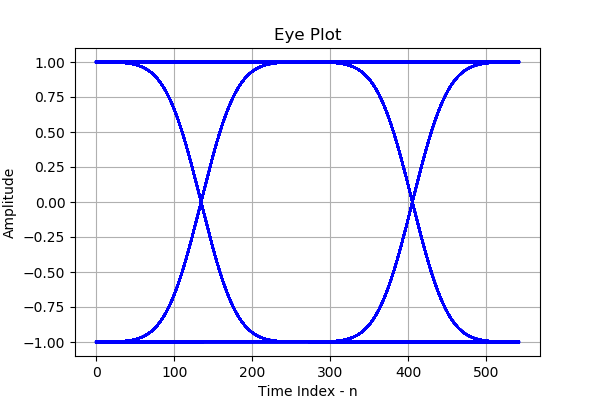

In [29]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(Señal_Tx[Ns*5:],L,S)  # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

In [8]:
samples = Señal_Tx[Ns*5::Ns]
minimo = min(samples[samples>0])
maximo = max(samples[samples<0])
aux = min(np.abs(minimo),np.abs(maximo))
ISIS = aux/1
print(ISIS)

0.952823812397412


## Generamos la señal FSK

<IPython.core.display.Javascript object>


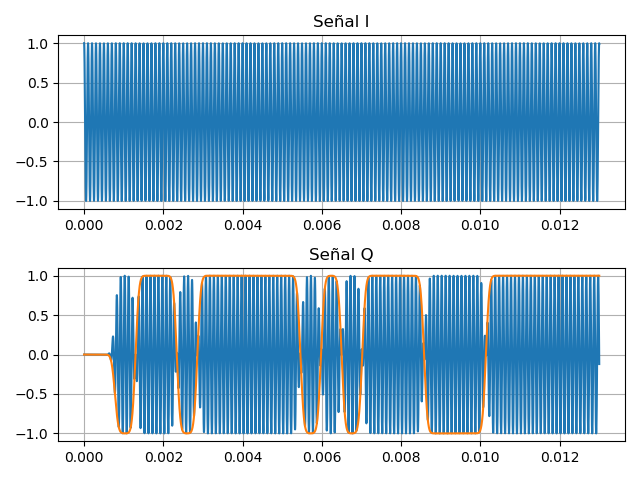

In [30]:
# Señales Modulantes
Cos_DeltaF = np.cos(2*np.pi*(DeltaF)*(t*ts))
Sin_DeltaF = np.sin(2*np.pi*(DeltaF)*(t*ts))


I = Cos_DeltaF
Q = -1 * Sin_DeltaF*(Señal_Tx) # Señal_Tx -> señal de datos, toma valores -1 y 1
Señal_IQ  = I + 1j*Q


plt.figure()
plt.subplot(211)
plt.plot(ts*t[0:Ns*25], I[0:Ns*25])
plt.grid()
plt.title("Señal I")
plt.subplot(212)
plt.plot(ts*t[0:Ns*25], Q[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Señal Q")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


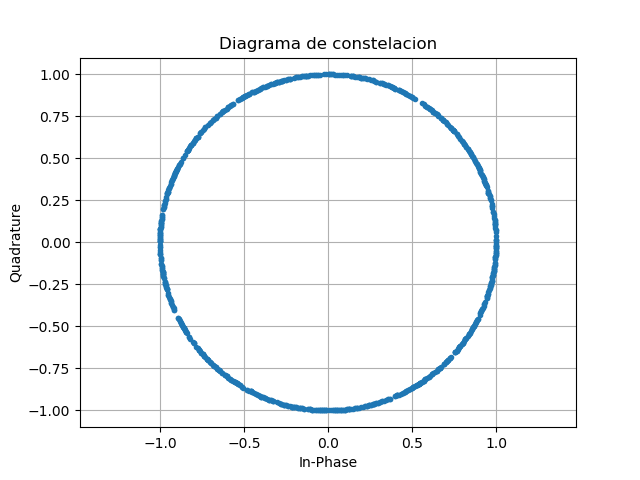

In [31]:
yI,yQ = dc.scatter(Señal_IQ,Ns,Ns*6)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.title("Diagrama de constelacion")
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


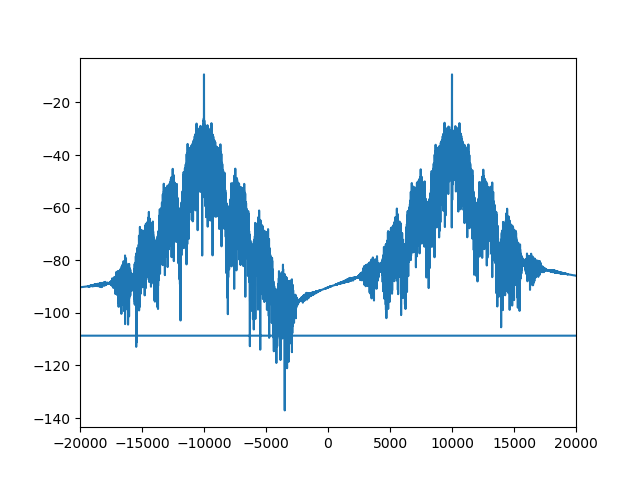

In [32]:
plt.figure()
N = Señal_IQ.shape[0]
Y = fft(Señal_IQ)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-20000,20000)
#plt.ylim(-90,0)
plt.show()

## Configuro la Pluto y transmito la señal
La modulacion de la portadora se realiza en la pluto

In [ ]:
#del(sdr)

In [12]:
import adi

sdr = adi.Pluto()

sdr.rx_lo = Fc # [Hz]
sdr.rx_buffer_size = len(Señal_IQ)
sdr.rx_cyclic_buffer = True

sdr.tx_destroy_buffer()
sdr.tx_lo = Fc # [Hz]
sdr.tx_cyclic_buffer = True
sdr.tx_hardwaregain_chan0 = -10
sdr.gain_control_mode_cahn0 = "slow_attack"
sdr.sample_rate = fs # [Hz]

fs_pluto = int(sdr.sample_rate)
print('fs =',fs_pluto)

# Send data
sdr.tx(Señal_IQ*2**14)

fs = 520999


In [ ]:
sdr.tx_destroy_buffer()
sdr.tx(Señal_IQ*2**14)

In [39]:
sdr.rx_rf_bandwidth = 20000

## Recibo la señal

(271000,)


<IPython.core.display.Javascript object>


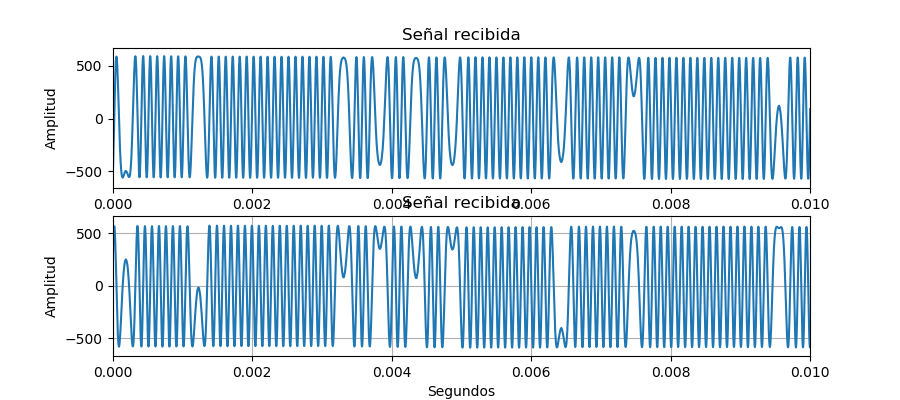

In [41]:
signal_rx = sdr.rx()
print(signal_rx.shape)
plt.figure(figsize=(9,4))
plt.subplot(211)
plt.plot(t*ts, np.real(signal_rx))
plt.title("Señal recibida")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.xlim(0,0.01)
plt.subplot(212)
plt.plot(t*ts, np.imag(signal_rx))
plt.title("Señal recibida")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.xlim(0,0.01)
plt.grid()

## FFT, señal Recibida

<IPython.core.display.Javascript object>


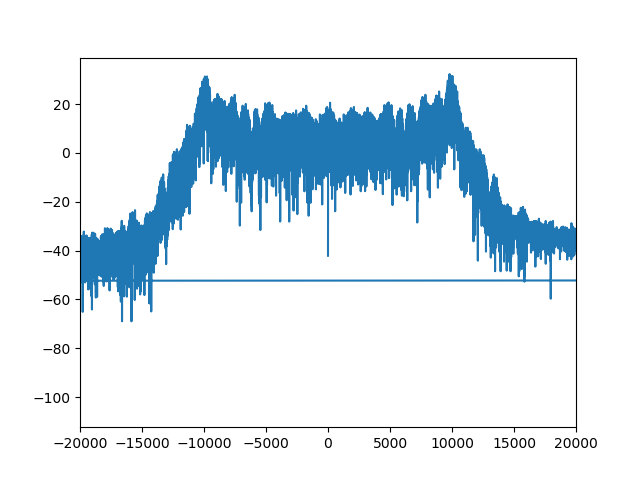

In [42]:
plt.figure()
N = signal_rx.shape[0]
Y = fft(signal_rx)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-20000,20000)
#plt.ylim(-90,0)
plt.show()

<IPython.core.display.Javascript object>


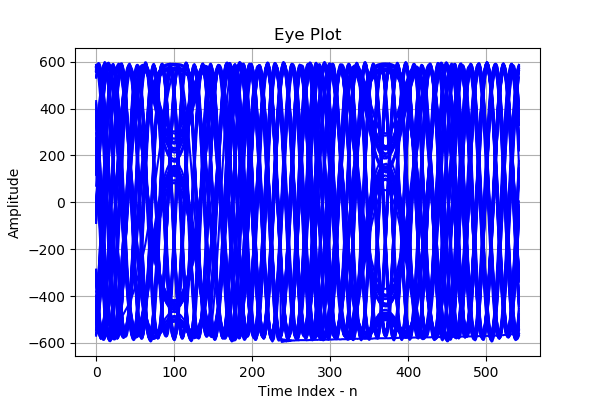

C:\Users\PC-Admin\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [43]:
L = Ns*2        # display length in samples (usually two symbols)
S = 0           # start index
dc.eye_plot(signal_rx[Ns*250:Ns*500],L,S)  # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
plt.show()

<IPython.core.display.Javascript object>


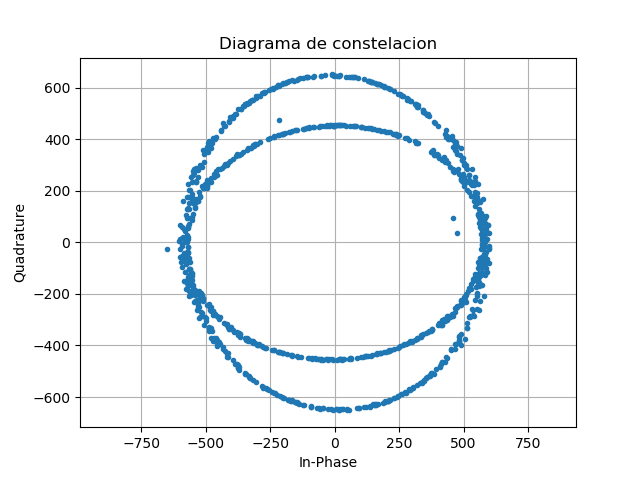

In [16]:
yI,yQ = dc.scatter(signal_rx,Ns,Ns*6)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.title("Diagrama de constelacion")
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

In [ ]:
plt.figure()
plt.plot(np.real(signal_rx[:5000]),np.imag(signal_rx[:5000]),'.')
plt.axis('equal')

------------------------------------------------------------------------------------------------

## Segunda parte - fase como entrada

<IPython.core.display.Javascript object>


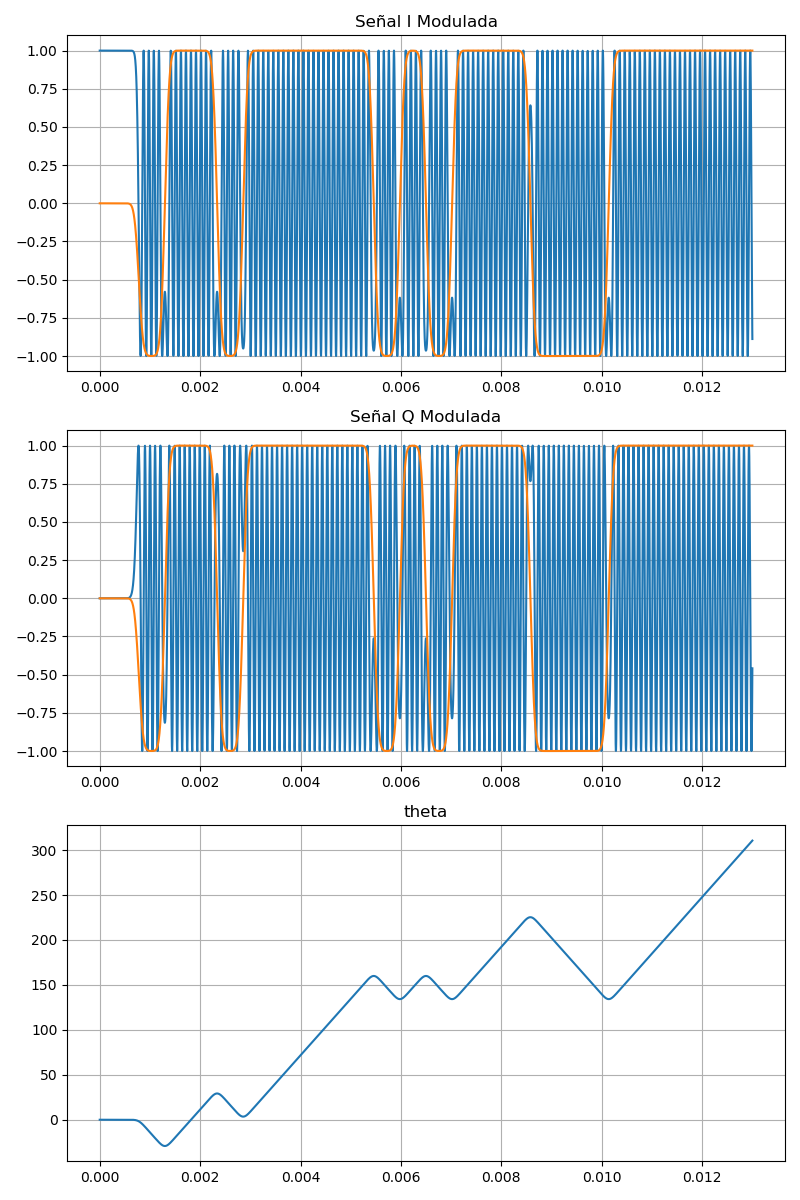

In [33]:
# Señales Modulantes
#theta = (t*ts)*2*np.pi*DeltaF
#theta = theta*(Señal_Tx)

# Integracion
theta = []
theta_acumulada = 0
for i_señal_tx in Señal_Tx:
    theta_acumulada += i_señal_tx*(ts)*(2*np.pi)*DeltaF
    theta.append(theta_acumulada)


Cos_theta = np.cos(theta)
Sin_theta = np.sin(theta)



# Modulacion de las portadoras
I = Cos_theta
Q = -1 * Sin_theta
Señal_IQ  = I + 1j*Q


plt.figure(figsize=(8,12))
plt.subplot(311)
plt.plot(ts*t[0:Ns*25], I[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Señal I Modulada")
plt.subplot(312)
plt.plot(ts*t[0:Ns*25], Q[0:Ns*25])
plt.plot(ts*t[0:Ns*25], Señal_Tx[0:Ns*25])
plt.grid()
plt.title("Señal Q Modulada")
plt.subplot(313)
plt.plot(ts*t[0:Ns*25], theta[0:Ns*25])
plt.grid()
plt.title("theta")
plt.tight_layout()
plt.show()

## Configuro la Pluto y transmito la señal
La modulacion de la portadora se realiza en la pluto

In [34]:
#import adi

#sdr = adi.Pluto()

#sdr.rx_lo = int(1e9) # [Hz]
#sdr.rx_buffer_size = len(Señal_IQ)

#sdr.tx_destroy_buffer()
#sdr.tx_lo = int(1e9) # [Hz]
#sdr.tx_cyclic_buffer = True
#sdr.tx_hardwaregain_chan0 = -10
#sdr.gain_control_mode_cahn0 = "slow_attack"
#sdr.sample_rate = fs # [Hz]

#fs_pluto = int(sdr.sample_rate)
#print('fs =',fs_pluto)

# Send data
sdr.tx_destroy_buffer()
sdr.tx(Señal_IQ*2**14)

## Recibo la señal

(271000,)


<IPython.core.display.Javascript object>


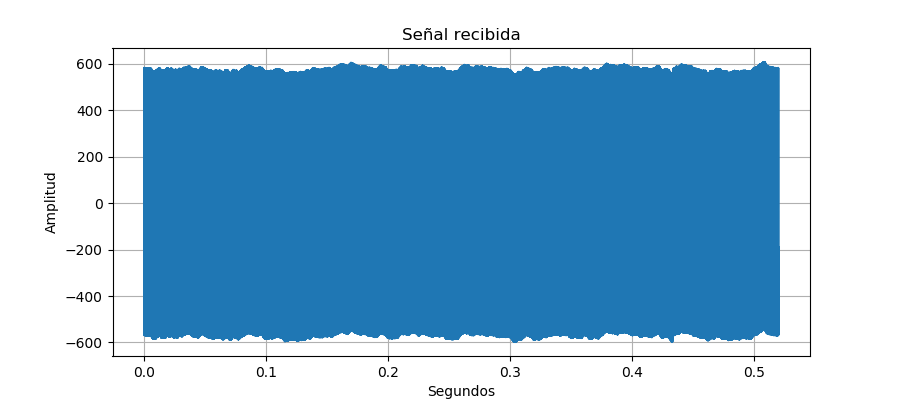

In [35]:
signal_rx = sdr.rx()
print(signal_rx.shape)
plt.figure(figsize=(9,4))
plt.plot(t*ts, np.real(signal_rx))
plt.title("Señal recibida")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
#plt.xlim(0,0.01)
plt.grid()

## FFT, señal Recibida

<IPython.core.display.Javascript object>


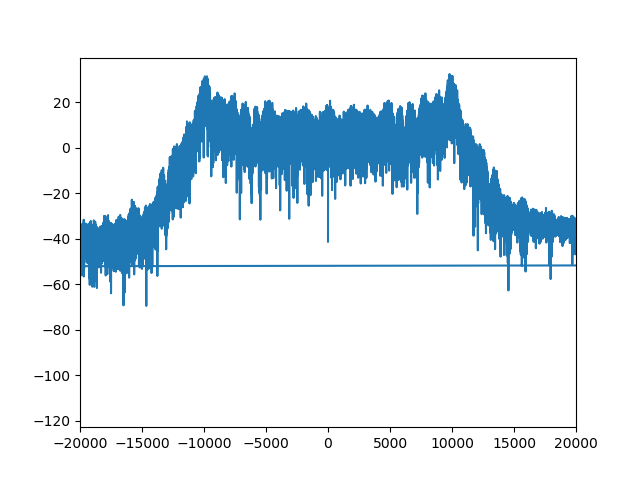

In [36]:
plt.figure()
N = signal_rx.shape[0]
Y = fft(signal_rx)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.xlim(-20000,20000)
#plt.ylim(-90,0)
plt.show()

<IPython.core.display.Javascript object>


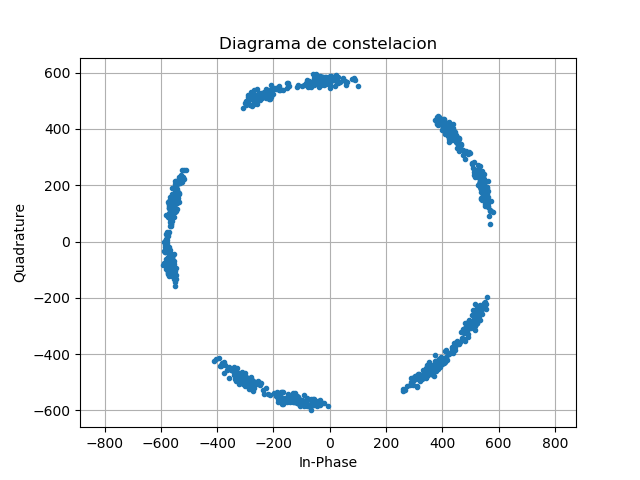

In [37]:
yI,yQ = dc.scatter(signal_rx,Ns,Ns*6)
plt.figure()
plt.plot(yI,yQ,'.')
plt.grid()
plt.title("Diagrama de constelacion")
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.axis('equal')
plt.show()

------------------------------------------------------------------------------------------------